# Predict the Introverts from the Extroverts

In this notebook, we will be predicting the introverts from the extroverts based on the given dataset. You can find the competition and the dataset [here](https://www.kaggle.com/competitions/playground-series-s5e7).

<div align="center">
<img src="https://www.kaggle.com/competitions/91718/images/header" />
</div>

## 1. Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import miceforest as mf
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from tqdm.notebook import tqdm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import warnings

### Configurations

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('darkgrid')

## 2. Loading Data

In [3]:
df = pd.read_csv('train.csv', index_col='id')

In [4]:
df.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
id,,,,,,,,
0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [5]:
df.shape

(18524, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18524 entries, 0 to 18523
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           17334 non-null  float64
 1   Stage_fear                 16631 non-null  object 
 2   Social_event_attendance    17344 non-null  float64
 3   Going_outside              17058 non-null  float64
 4   Drained_after_socializing  17375 non-null  object 
 5   Friends_circle_size        17470 non-null  float64
 6   Post_frequency             17260 non-null  float64
 7   Personality                18524 non-null  object 
dtypes: float64(5), object(3)
memory usage: 1.3+ MB


In [7]:
df.isnull().sum()

Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64

In [8]:
df.dropna(inplace=True)
df.shape

(10189, 8)

## 3. Exploratory Data Analysis

In [9]:
# Copy of the original dataframe
dfo = df.copy()

In [10]:
df['Stage_fear'] = df['Stage_fear'].map({'Yes': 1, 'No': 0})
df['Drained_after_socializing'] = df['Drained_after_socializing'].map({'Yes': 1, 'No': 0})

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time_spent_Alone,10189.0,2.633134,2.630621,0.0,1.0,2.0,3.0,11.0
Stage_fear,10189.0,0.166945,0.372945,0.0,0.0,0.0,0.0,1.0
Social_event_attendance,10189.0,5.681519,2.597142,0.0,4.0,6.0,8.0,10.0
Going_outside,10189.0,4.444793,1.884790,0.0,3.0,5.0,6.0,7.0
Drained_after_socializing,10189.0,0.167043,0.373032,0.0,0.0,0.0,0.0,1.0
Friends_circle_size,10189.0,8.503092,4.073302,0.0,5.0,9.0,12.0,15.0
Post_frequency,10189.0,5.500834,2.709847,0.0,3.0,6.0,8.0,10.0


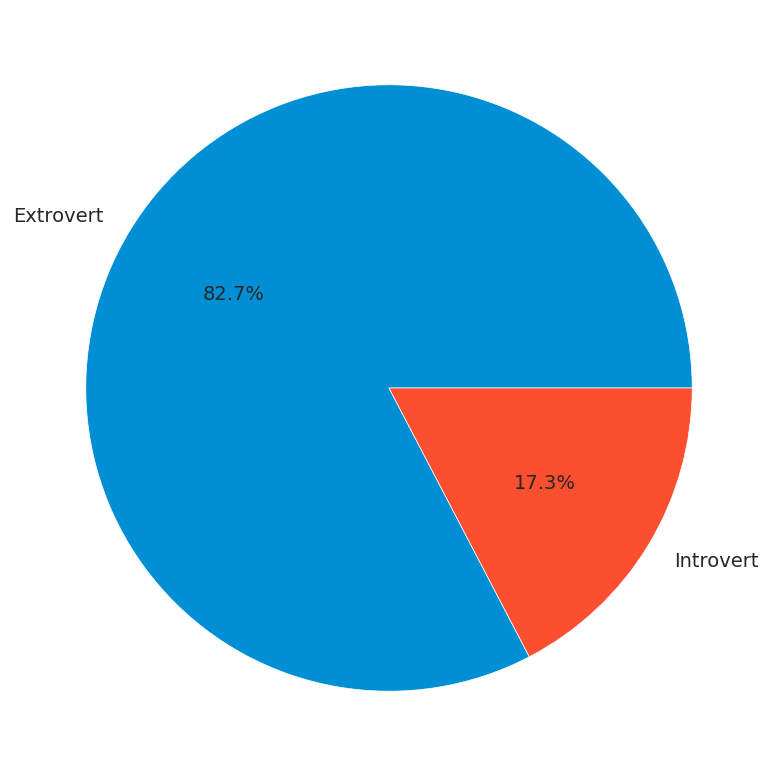

In [12]:
df['Personality'].value_counts().plot.pie(autopct='%1.1f%%')
plt.ylabel('')
plt.tight_layout()

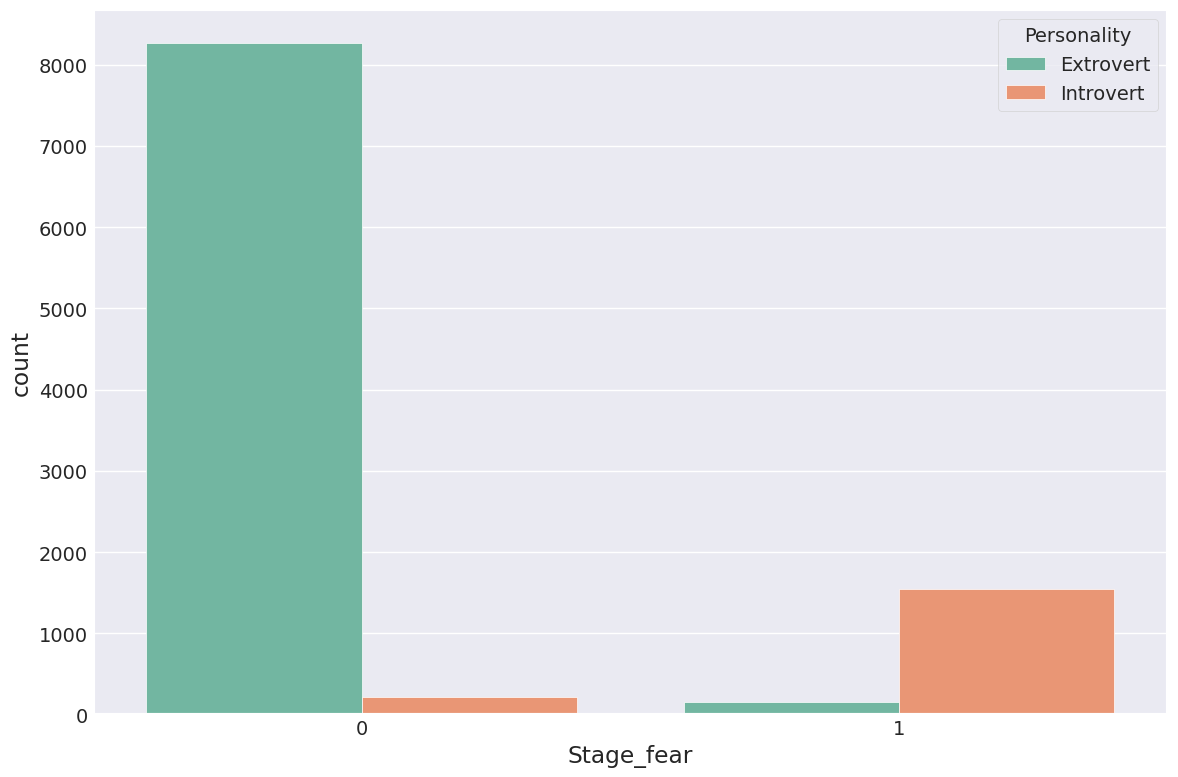

In [13]:
sns.countplot(df, x='Stage_fear', hue='Personality', palette='Set2')
plt.tight_layout()

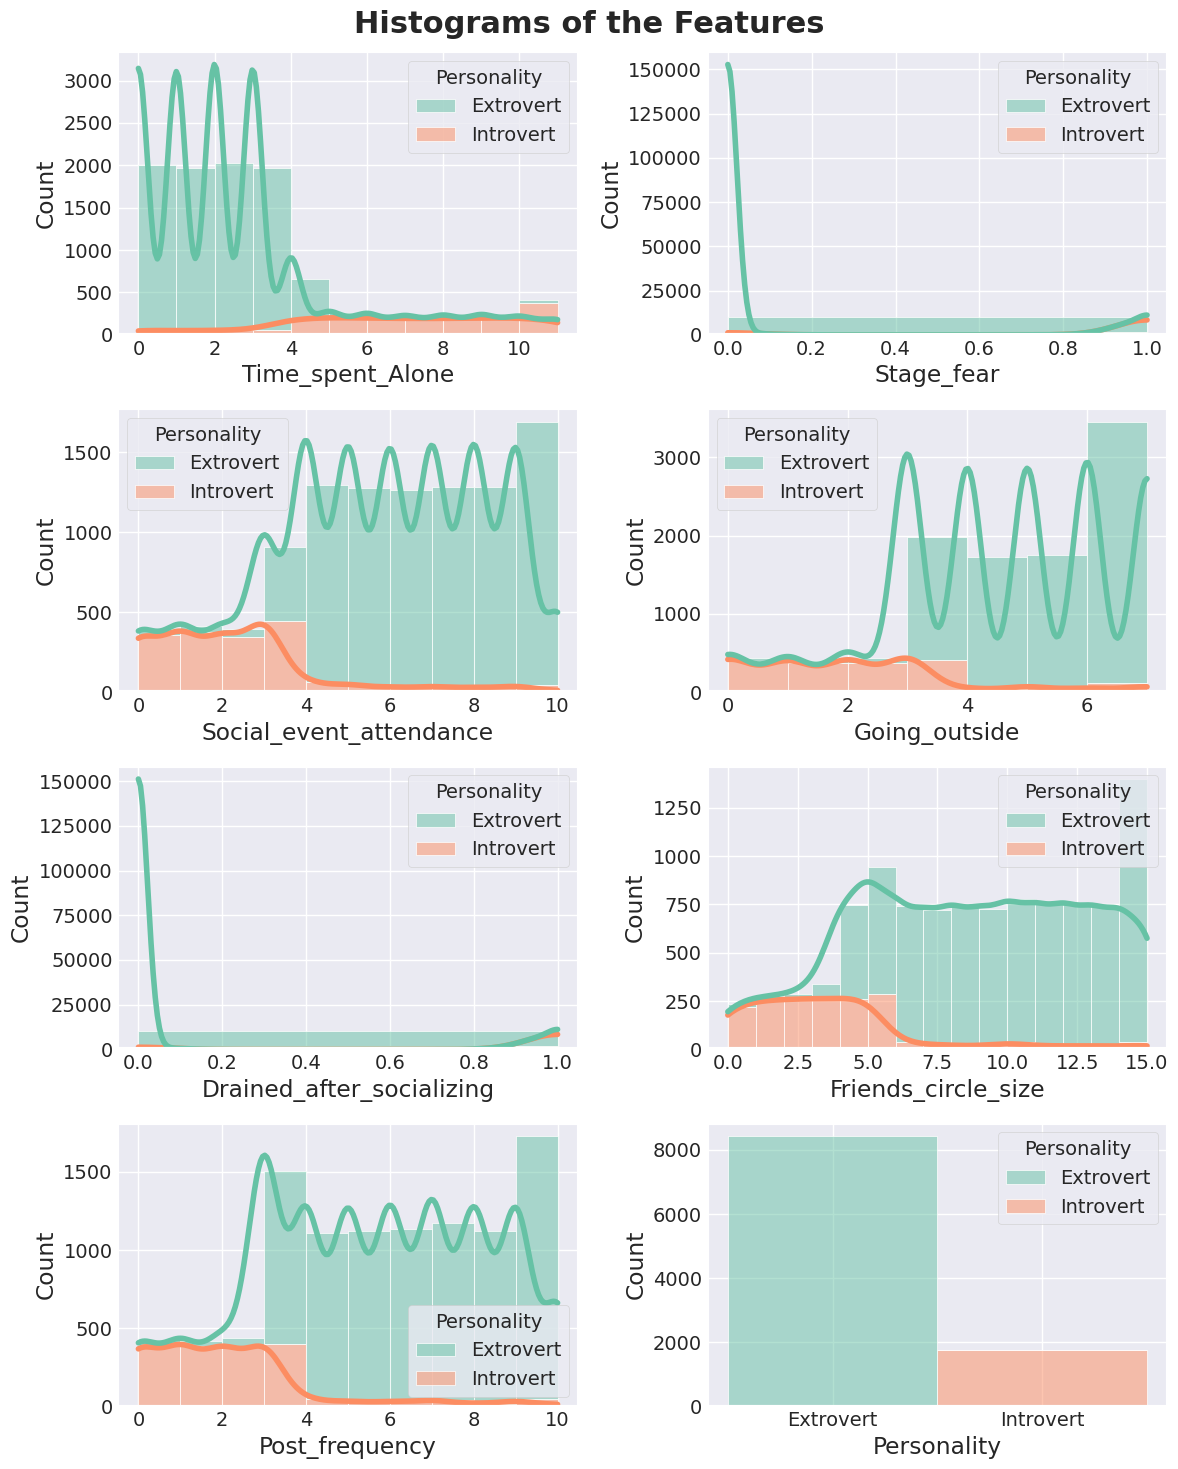

In [14]:
plt.figure(figsize=(12, 15))
for i, c in enumerate(df.columns):
    plt.subplot(4, 2, i + 1)
    sns.histplot(
        x=df[c],
        bins=40,
        binwidth=1,
        hue=df['Personality'],
        multiple='stack',
        palette='Set2',
        kde=True,
    )
plt.suptitle('Histograms of the Features', fontsize=22, fontweight='bold')
plt.tight_layout()

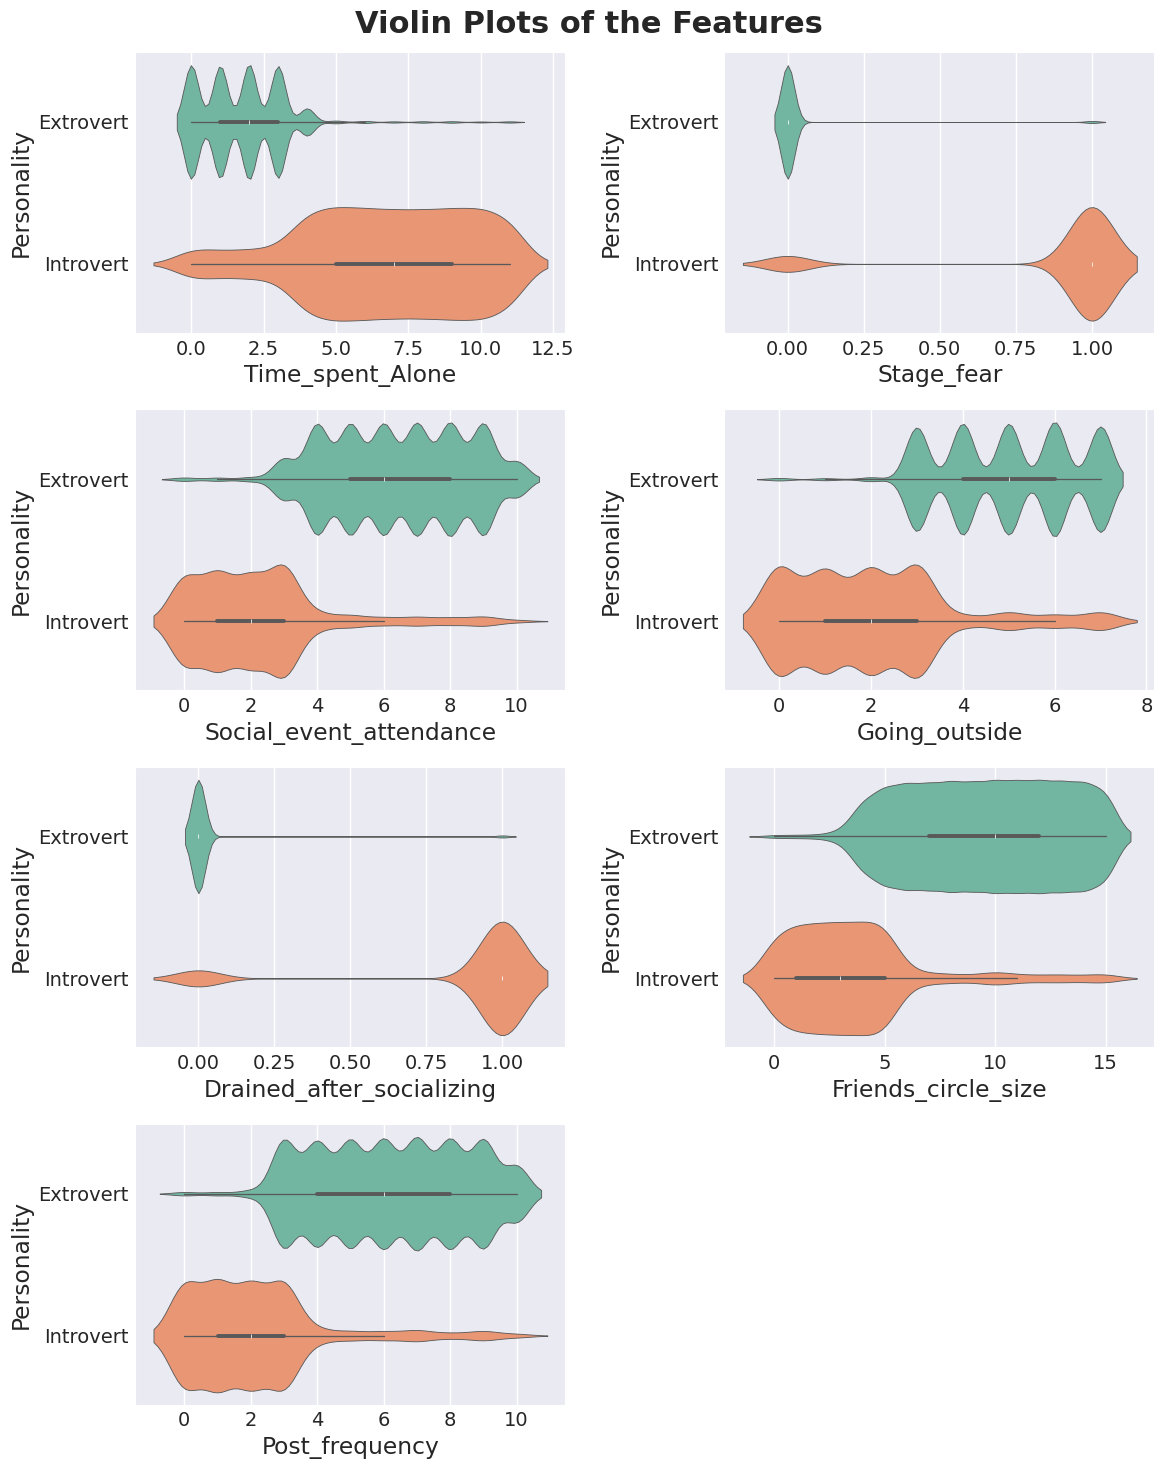

In [15]:
plt.figure(figsize=(12, 15))
for i, c in enumerate(df.columns[:-1]):
    plt.subplot(4, 2, i + 1)
    sns.violinplot(
        x=df[c],
        y=df['Personality'],
        hue=df['Personality'],
        palette='Set2'
    )
plt.suptitle('Violin Plots of the Features', fontsize=22, fontweight='bold')
plt.tight_layout()

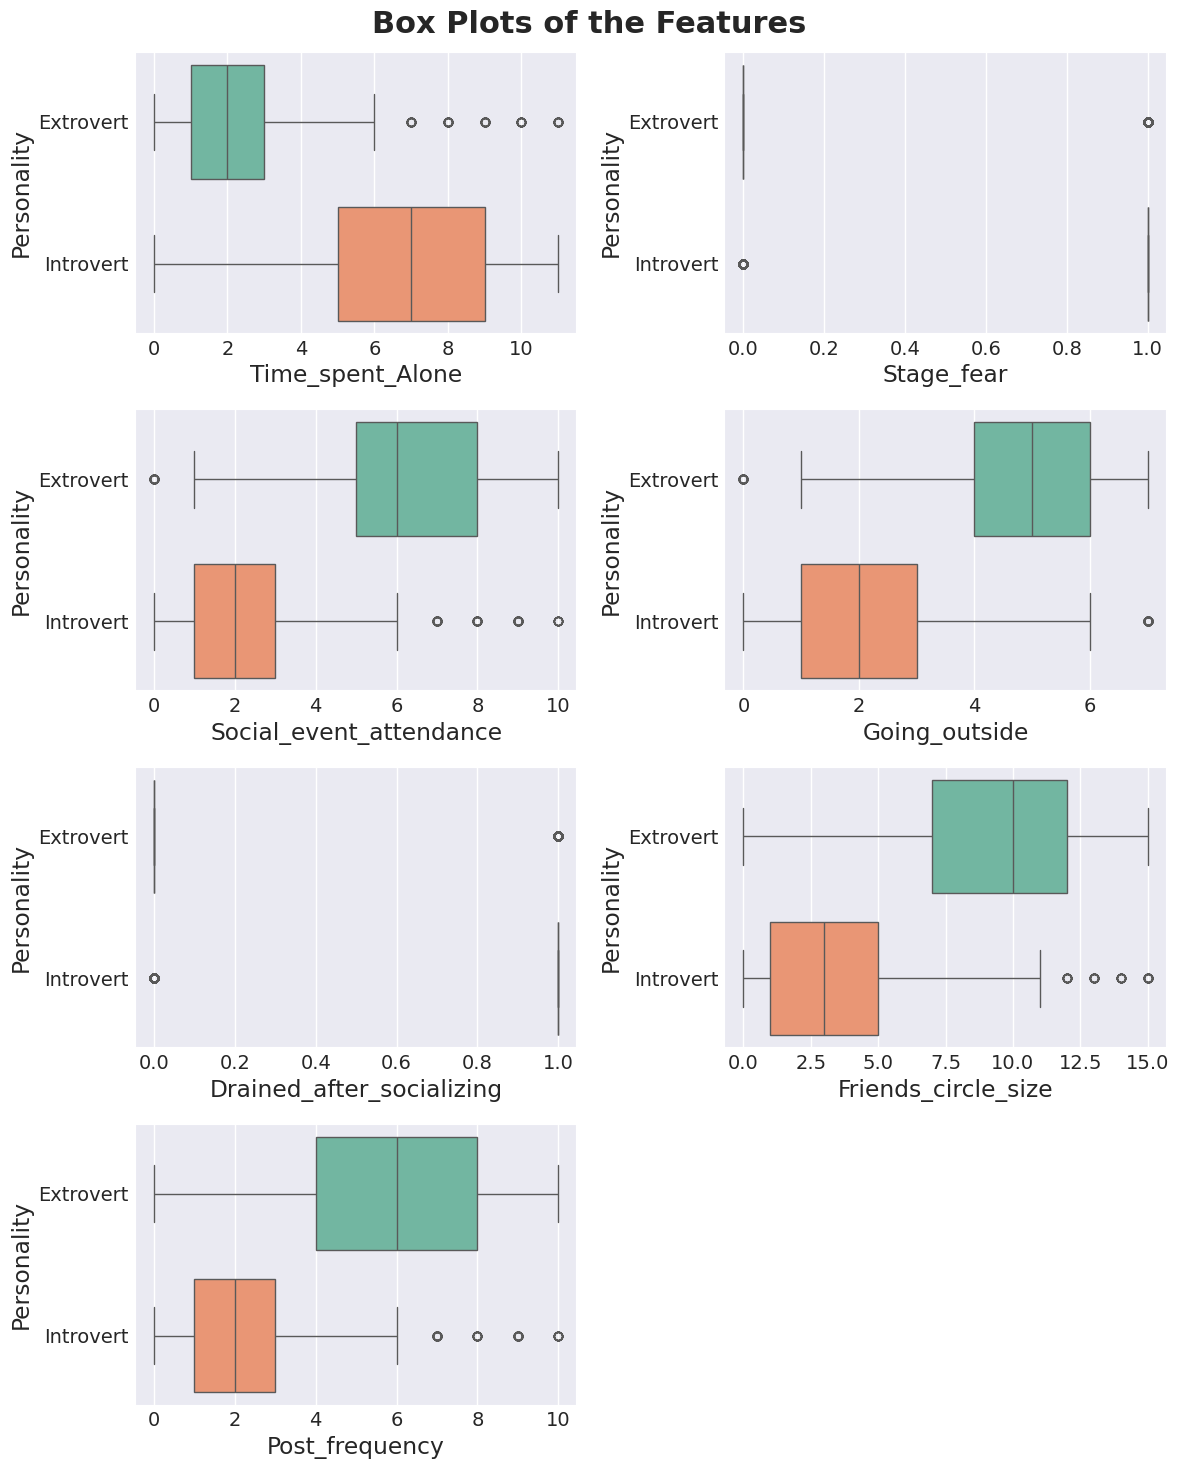

In [16]:
plt.figure(figsize=(12, 15))
for i, c in enumerate(df.columns[:-1]):
    plt.subplot(4, 2, i + 1)
    sns.boxplot(
        x=df[c],
        y=df['Personality'],
        hue=df['Personality'],
        palette='Set2'
    )
plt.suptitle('Box Plots of the Features', fontsize=22, fontweight='bold')
plt.tight_layout()

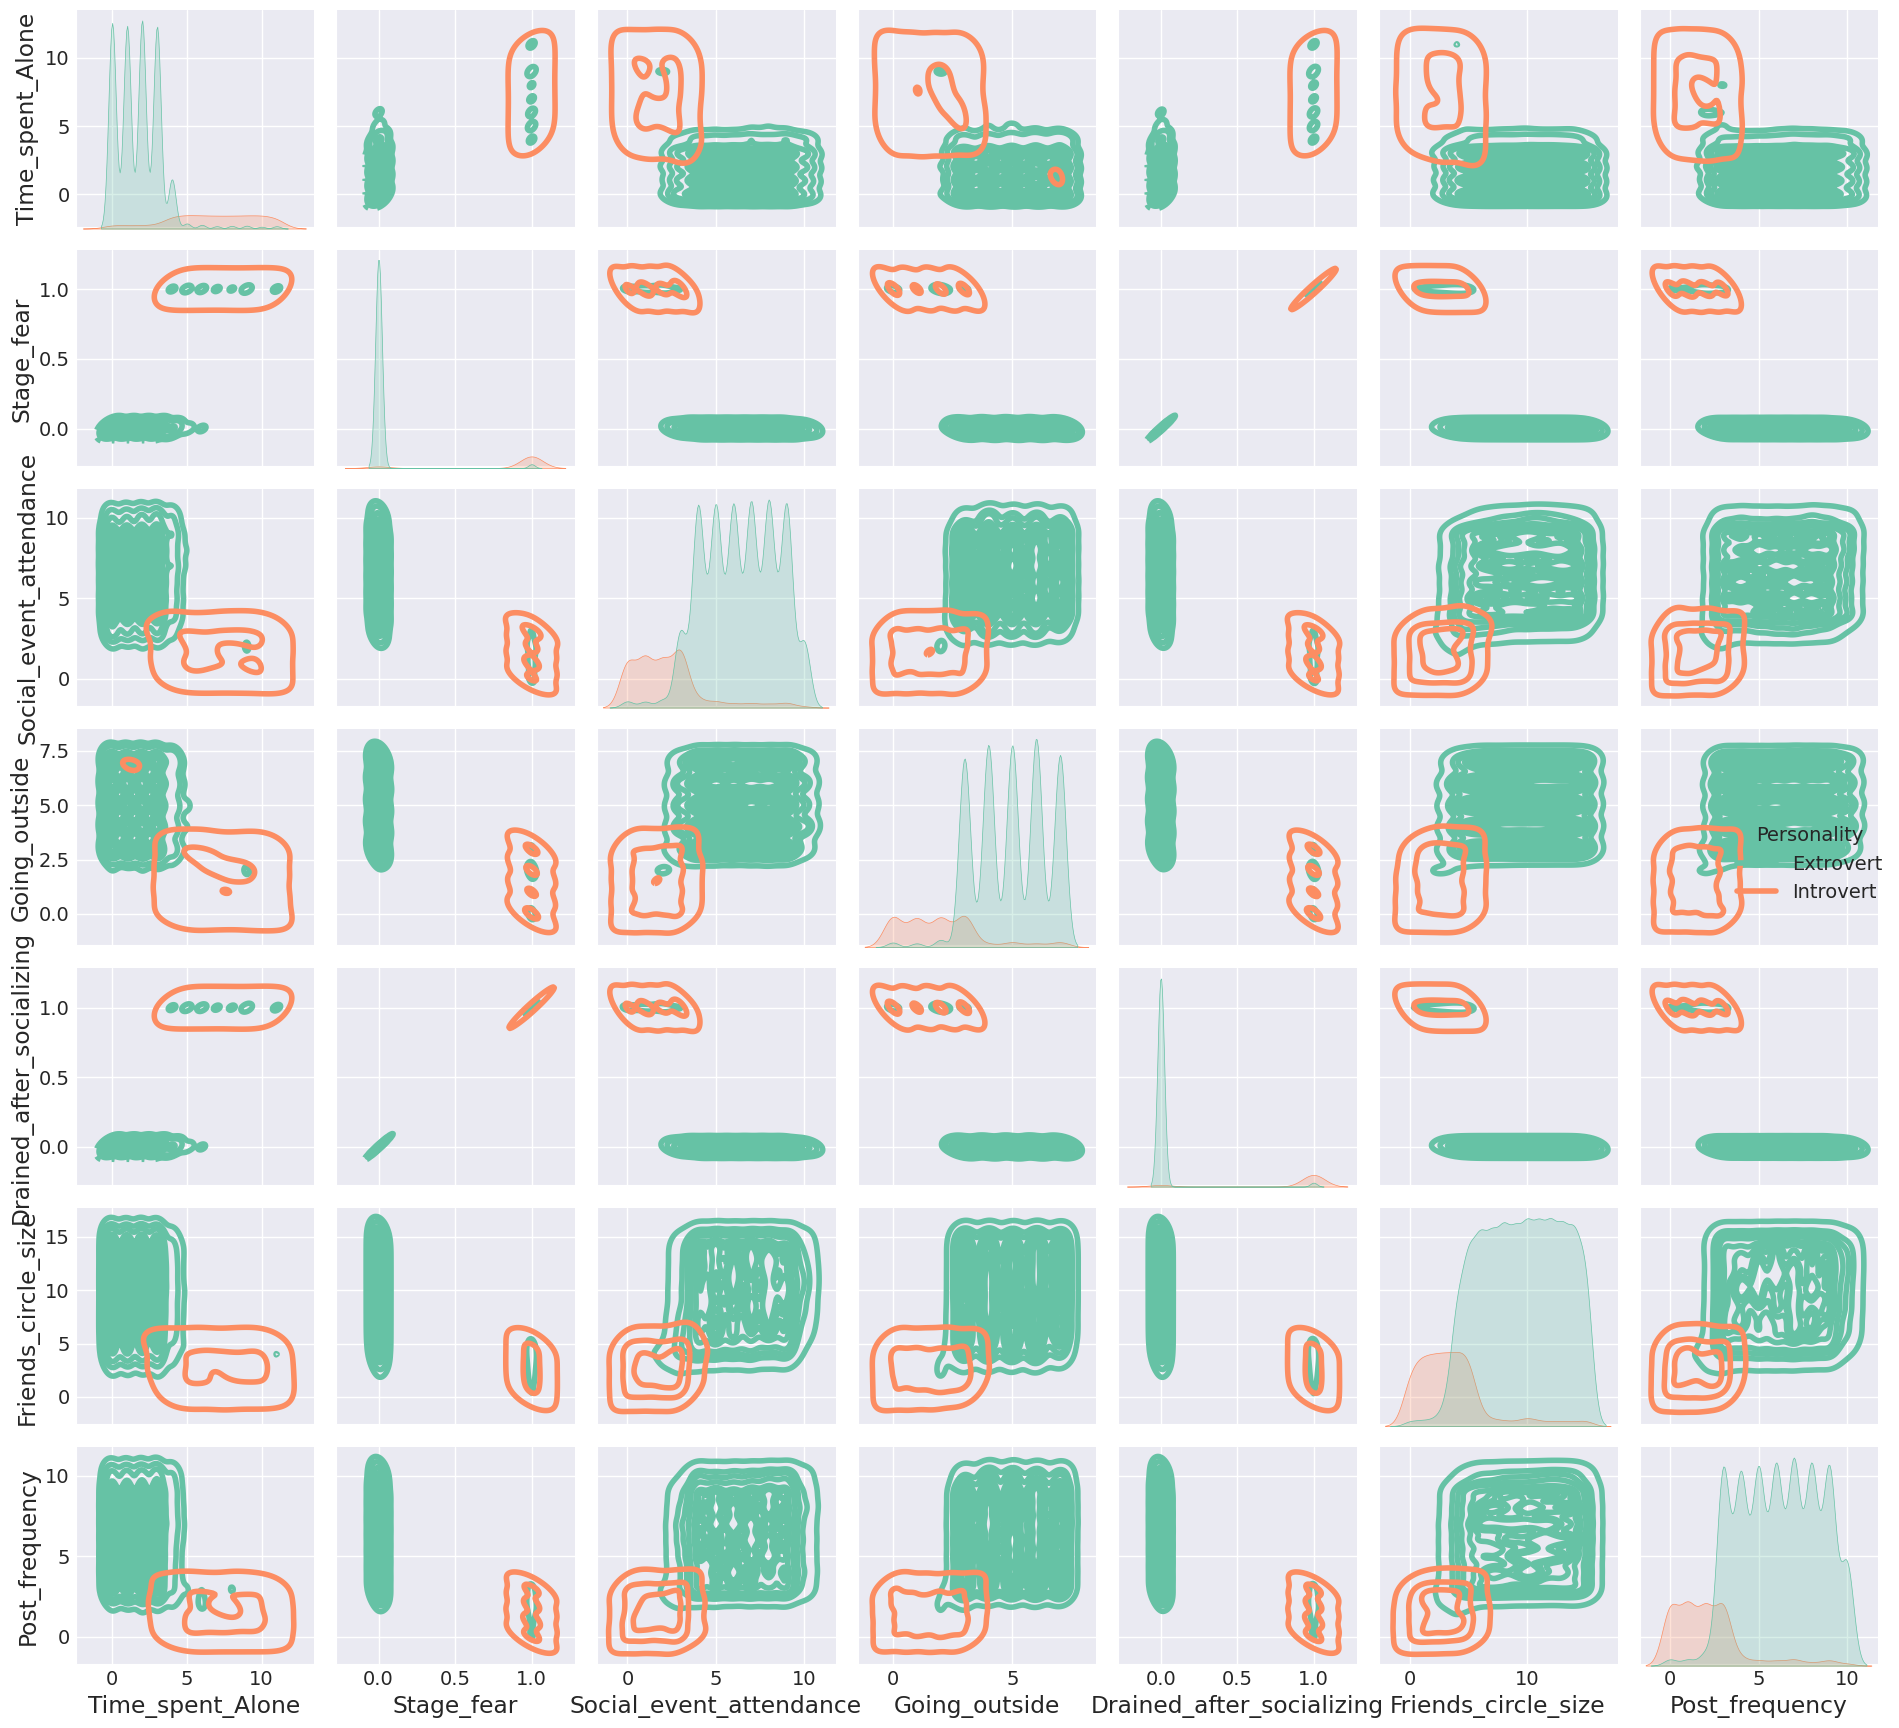

In [17]:
sns.pairplot(df, hue='Personality', kind='kde', palette='Set2')
plt.tight_layout()

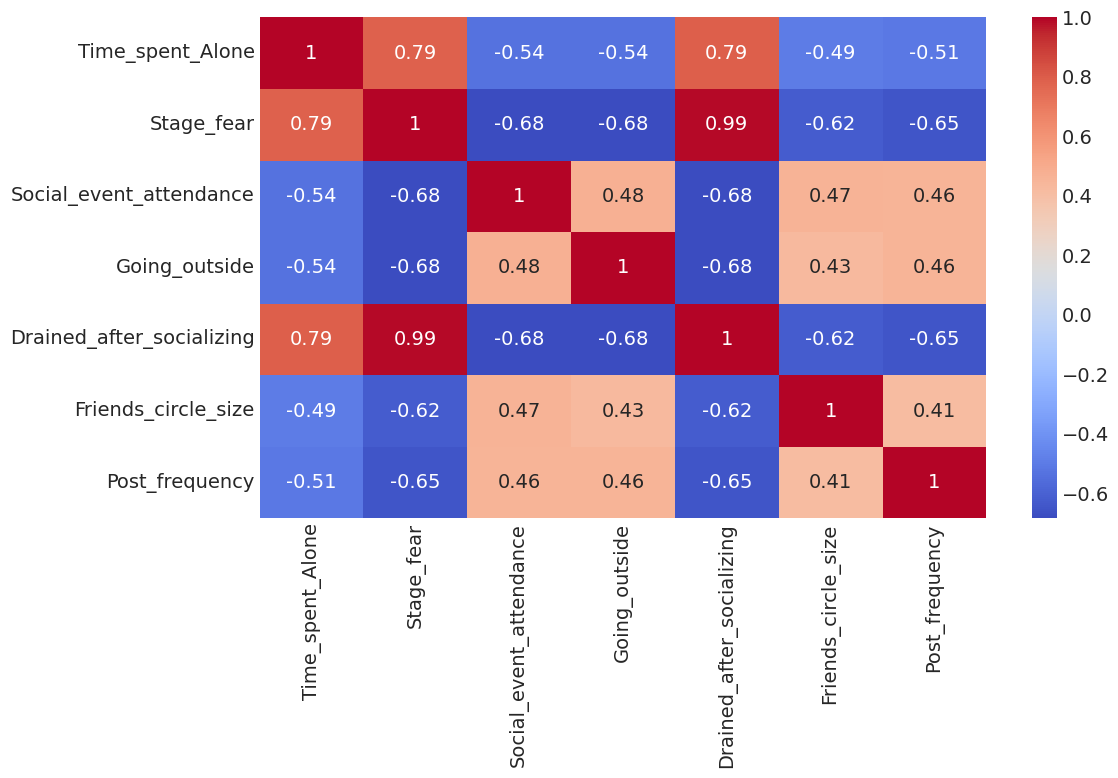

In [18]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.tight_layout()

## 4. Data Preprocessing

In [19]:
x = df.drop(columns=['Personality'])
y = df['Personality']

In [20]:
y_encoded = y.map({'Introvert': 0, 'Extrovert': 1})

In [21]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_encoded, test_size=0.2, random_state=42)

## 5. Model Training

In [23]:
models = {
    'GaussianNB': GaussianNB(),
    'MultinomialNB': MultinomialNB(),
    'BernoulliNB': BernoulliNB(),
    'LogisticRegression': LogisticRegression(),
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=5),
    'SVC': SVC(),
    'XGBClassifier': xgb.XGBClassifier(),
    'LightGBMClassifier': lgb.LGBMClassifier(verbose=-1)
}

def evaluate(x_train, y_train, x_test, y_test):
    results = []

    for i, (model_name, model) in enumerate(tqdm(models.items())):
        if 'random_state' in model.get_params():
            model.set_params(random_state=42)

        print(f'Training {model_name}...')
        y_pred = model.fit(x_train, y_train).predict(x_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')

        plt.subplot(3, 5, i+1)
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(model_name, fontsize=12)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()

        results.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })
        
    plt.suptitle('Confusion Matrices of All Models')
    plt.tight_layout()
    
    report = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
    report.reset_index(drop=True, inplace=True)
    return report

  0%|          | 0/12 [00:00<?, ?it/s]

Training GaussianNB...
Training MultinomialNB...
Training BernoulliNB...
Training LogisticRegression...
Training ExtraTreesClassifier...
Training DecisionTreeClassifier...
Training RandomForestClassifier...
Training GradientBoostingClassifier...
Training KNeighborsClassifier...
Training SVC...
Training XGBClassifier...
Training LightGBMClassifier...


,Model,Accuracy,Precision,Recall,F1 Score
0,GradientBoostingClassifier,0.958783,0.928958,0.920776,0.924802
1,KNeighborsClassifier,0.958292,0.929398,0.918112,0.923631
2,GaussianNB,0.957802,0.926277,0.920188,0.923196
3,MultinomialNB,0.957802,0.928038,0.917818,0.922825
4,SVC,0.957802,0.928038,0.917818,0.922825
5,BernoulliNB,0.957311,0.927577,0.916338,0.921834
6,LogisticRegression,0.957311,0.927577,0.916338,0.921834
7,ExtraTreesClassifier,0.957311,0.926686,0.917523,0.922022
8,RandomForestClassifier,0.957311,0.926686,0.917523,0.922022
9,LightGBMClassifier,0.956820,0.924478,0.918415,0.921410


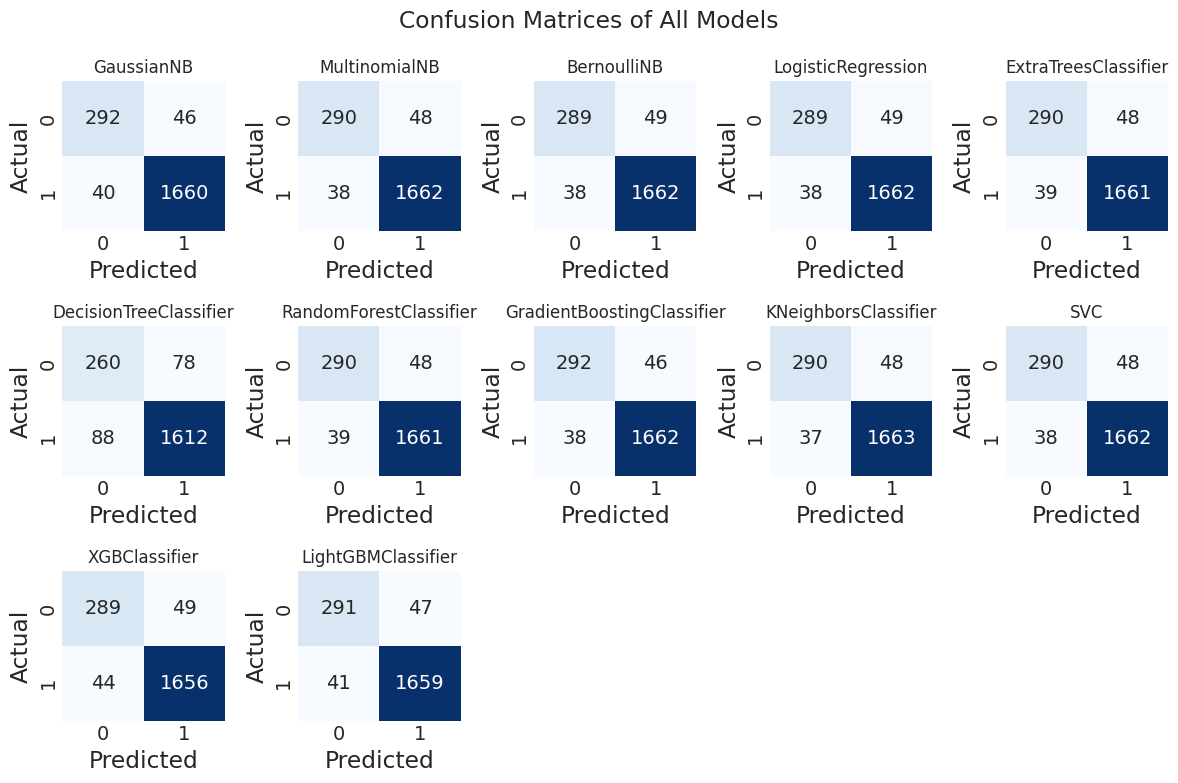

In [24]:
evaluate(x_train, y_train, x_test, y_test)

## 6. Build Pipeline with the best model, Save the model, Make Submission

In [25]:
x = dfo.drop(columns=['Personality'])
y = dfo['Personality']

In [26]:
preprocessor = ColumnTransformer([
    ('scaler', MinMaxScaler(), ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']),
    ('encoder', OrdinalEncoder(), ['Stage_fear', 'Drained_after_socializing'])
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingClassifier(random_state=42))
])
pipeline.fit(x, y)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scaler', ...), ('encoder', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [27]:
y_pred = pipeline.predict(x)

In [28]:
confusion_matrix(y, y_pred)

array([[8290,  132],
       [ 201, 1566]])

In [29]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

   Extrovert       0.98      0.98      0.98      8422
   Introvert       0.92      0.89      0.90      1767

    accuracy                           0.97     10189
   macro avg       0.95      0.94      0.94     10189
weighted avg       0.97      0.97      0.97     10189



In [30]:
joblib.dump(pipeline, 'extrovert_introvert_classifier.pkl')

['extrovert_introvert_classifier.pkl']

In [31]:
test_df = pd.read_csv('test.csv')
test_df.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,18524,3.0,No,7.0,4.0,No,6.0,NaN
1,18525,NaN,Yes,0.0,0.0,Yes,5.0,1.0
2,18526,3.0,No,5.0,6.0,No,15.0,9.0
3,18527,3.0,No,4.0,4.0,No,5.0,6.0
4,18528,9.0,Yes,1.0,2.0,Yes,1.0,1.0


In [32]:
test_df.isnull().sum()

id                             0
Time_spent_Alone             425
Stage_fear                   598
Social_event_attendance      397
Going_outside                466
Drained_after_socializing    432
Friends_circle_size          350
Post_frequency               408
dtype: int64

In [33]:
test_df = test_df.astype({'Stage_fear': 'category', 'Drained_after_socializing': 'category'})

In [34]:
kernel = mf.ImputationKernel(
    data=test_df.iloc[:, 1:],
    random_state=42
)
kernel.mice(5)

In [35]:
imputed_df = kernel.complete_data()
imputed_df.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,3.0,No,7.0,4.0,No,6.0,10.0
1,7.0,Yes,0.0,0.0,Yes,5.0,1.0
2,3.0,No,5.0,6.0,No,15.0,9.0
3,3.0,No,4.0,4.0,No,5.0,6.0
4,9.0,Yes,1.0,2.0,Yes,1.0,1.0


In [36]:
test_df = pd.concat([test_df['id'], imputed_df], axis=1)
test_df.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,18524,3.0,No,7.0,4.0,No,6.0,10.0
1,18525,7.0,Yes,0.0,0.0,Yes,5.0,1.0
2,18526,3.0,No,5.0,6.0,No,15.0,9.0
3,18527,3.0,No,4.0,4.0,No,5.0,6.0
4,18528,9.0,Yes,1.0,2.0,Yes,1.0,1.0


In [37]:
predictions = pipeline.predict(test_df.iloc[:, 1:])
submission = pd.DataFrame({
    'id': test_df['id'],
    'Personality': predictions
})
submission.head()

,id,Personality
0,18524,Extrovert
1,18525,Introvert
2,18526,Extrovert
3,18527,Extrovert
4,18528,Introvert


In [38]:
submission.to_csv('submission.csv', index=False)

## 7. Conclusion
We built a machine learning pipeline to predict the introverts from the extroverts. We used the `GradientBoostingClassifier` as the best model. We also used the `miceforest` library to impute the missing values. We saved the pipeline for future use and used it to generate predictions for the test set.